In [6]:
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import load_model

In [7]:
# --- Rutas de Archivos ---
PROCESSED_PATH = "data_processed"
MODELS_PATH = "." # Asumimos que los modelos están en la carpeta principal

# --- 1. Carga de Modelos ---
print("Cargando Modelos...")
modelo_lstm_diario = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_diario.h5'))
modelo_gru_diario = load_model(os.path.join(MODELS_PATH, 'modelo_gru_diario.h5'))

modelo_lstm_horario = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_horario.h5')) # Asumiendo formato Keras sin extensión
modelo_gru_horario = load_model(os.path.join(MODELS_PATH, 'modelo_gru_horario.h5'))   # Asumiendo formato Keras sin extensión

modelo_lstm_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_lstm_cincoMinutos.keras'))
modelo_gru_minuto = load_model(os.path.join(MODELS_PATH, 'modelo_gru_cincoMinutos.keras'))

# --- 2. Carga de Escaladores ---
print("Cargando Escaladores...")
scaler_diario = joblib.load(os.path.join(MODELS_PATH, 'scaler_diario.pkl'))
scaler_horario = joblib.load(os.path.join(MODELS_PATH, 'scaler_horario.pkl'))
scaler_minuto = joblib.load(os.path.join(MODELS_PATH, 'scaler_cincoMinutos.pkl')) 

# --- 3. Carga de DataFrames de Testeo Final (Enero 2025) ---
print("Cargando Datasets de Testeo...")
# Usamos el DataFrame de entrenamiento/validación para obtener los datos pasados necesarios
df_diario_train_val = pd.read_csv(os.path.join(PROCESSED_PATH, "df_diario_train_val.csv"), index_col='timestamp', parse_dates=True)
df_horario_train_val = pd.read_csv(os.path.join(PROCESSED_PATH, "df_horario_train_val.csv"), index_col='timestamp', parse_dates=True)
df_minuto_train_val = pd.read_csv(os.path.join(PROCESSED_PATH, "df_cincoMinutos_train_val.csv"), index_col='timestamp', parse_dates=True)

# DataFrames de Testeo
df_diario_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_diario_test_final.csv"), index_col='timestamp', parse_dates=True)
df_horario_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_horario_test_final.csv"), index_col='timestamp', parse_dates=True)
df_minuto_test_final = pd.read_csv(os.path.join(PROCESSED_PATH, "df_cincoMinutos_test_final.csv"), index_col='timestamp', parse_dates=True)

# --- 4. Definición de Parámetros ---
# Reafirmamos los parámetros de ventana (los necesitamos para preparar X_test)
TIMESTEP_DIA = 60
TIMESTEP_HORA = 504
TIMESTEP_MINUTO = 864 

FEATURES_DIARIO = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']
FEATURES_HORARIO = ['open', 'high', 'low', 'close', 'volume', 'volatilidad']
FEATURES_MINUTO = ['close'] # Univariado

Cargando Modelos...


C:\Users\crges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Cargando Escaladores...
Cargando Datasets de Testeo...


In [10]:
## FUNCIONES AUXILIARES

def preparar_X_test(df_train_val, df_test_final, scaler, timestep, features):
    """
    Prepara el array X_test para un modelo, concatenando la cola necesaria de datos pasados
    y aplicando el escalador.
    """
    
    # 1. Crear la característica de Volatilidad si está en la lista de features
    if 'volatilidad' in features and len(features) > 1:
        df_train_val['volatilidad'] = df_train_val['high'] - df_train_val['low']
        df_test_final['volatilidad'] = df_test_final['high'] - df_test_final['low']
    
    # 2. Concatenar la "cola" de datos de entrenamiento (la ventana de TIMESTEP)
    # Seleccionamos solo las features necesarias
    dataset_completo = pd.concat((df_train_val[features].iloc[-timestep:], df_test_final[features]), axis=0)
    
    data_test = dataset_completo[features].values
    
    # 3. Escalar los datos
    scaled_test_data = scaler.transform(data_test)
    
    # 4. Crear las secuencias X_test
    X_test = []
    for i in range(timestep, len(scaled_test_data)):
        X_test.append(scaled_test_data[i-timestep:i, :])
    
    X_test = np.array(X_test)
    
    # Ajustar la forma para univariado (si es necesario)
    if len(features) == 1 and X_test.ndim == 2:
        X_test = np.expand_dims(X_test, axis=2)
        
    return X_test, df_test_final.loc[dataset_completo.index[timestep:]]

def desescalar_prediccion(predictions_scaled, scaler, features_full):
    """
    Convierte las predicciones escaladas (0-1) a precios reales en USD.
    """
    # El índice de 'close' siempre será 3 en la lista de 6 features estándar
    # Si FEATURES_FULL es solo ['close'], entonces el índice es 0.
    close_idx = features_full.index('close') if 'close' in features_full else 0
    
    # Crear un array dummy con el número de features completo del escalador (6)
    dummy_array = np.zeros(shape=(len(predictions_scaled), scaler.n_features_in_))
    
    # Colocar la predicción en la posición de 'close'
    dummy_array[:, close_idx] = predictions_scaled[:, 0]
    
    predictions_descaled = scaler.inverse_transform(dummy_array)
    precios_reales = predictions_descaled[:, close_idx]
    
    return precios_reales

In [11]:
## 1. PREPARACIÓN Y PREDICCIÓN DIARIA (LARGO PLAZO)

print("--- 1. Generando Predicción Diaria ---")

# 1. Preparar X_test Diario (Multi-Feature)
X_test_diario, df_diario_test_final_alineado = preparar_X_test(
    df_diario_train_val.copy(), 
    df_diario_test_final.copy(), 
    scaler_diario, 
    TIMESTEP_DIA, 
    FEATURES_DIARIO
)

# 2. Generar Predicciones Diarias (Promedio LSTM + GRU)
pred_scaled_lstm_diario = modelo_lstm_diario.predict(X_test_diario)
pred_scaled_gru_diario = modelo_gru_diario.predict(X_test_diario)

pred_scaled_diario_ensamble = (pred_scaled_lstm_diario + pred_scaled_gru_diario) / 2

# 3. Desescalar
pred_reales_diario = desescalar_prediccion(pred_scaled_diario_ensamble, scaler_diario, FEATURES_DIARIO)

# 4. Crear DataFrame de las Predicciones Diarias
df_prediccion_diaria = pd.DataFrame(
    pred_reales_diario, 
    index=df_diario_test_final_alineado.index, 
    columns=['pred_diaria']
)

print(f"✅ Predicción Diaria completa. Primeros 5 valores (USD): {df_prediccion_diaria.head().values.flatten()}")

--- 1. Generando Predicción Diaria ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
✅ Predicción Diaria completa. Primeros 5 valores (USD): [92359.92696414 92681.08820018 93670.1194422  94998.69986645
 96125.02495617]


In [12]:
## 2. PREPARACIÓN Y PREDICCIÓN HORARIA (MEDIANO PLAZO)

print("--- 2. Generando Predicción Horaria ---")

# 1. Preparar X_test Horario (6 features originales)
X_test_horario, df_horario_test_final_alineado = preparar_X_test(
    df_horario_train_val.copy(), 
    df_horario_test_final.copy(), 
    scaler_horario, 
    TIMESTEP_HORA, 
    FEATURES_HORARIO
)

# 2. Generar Predicciones Horarias (Promedio LSTM + GRU)
pred_scaled_horario = (modelo_lstm_horario.predict(X_test_horario) + modelo_gru_horario.predict(X_test_horario)) / 2

# 3. Desescalar
pred_reales_horario = desescalar_prediccion(pred_scaled_horario, scaler_horario, FEATURES_HORARIO)

# 4. Guardar en DataFrame
df_prediccion_horaria = pd.DataFrame(
    pred_reales_horario, 
    index=df_horario_test_final_alineado.index, 
    columns=['pred_horaria']
)

print(f"✅ Predicción Horaria completa. Número de puntos: {len(df_prediccion_horaria)}")

--- 2. Generando Predicción Horaria ---
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step
✅ Predicción Horaria completa. Número de puntos: 6400


In [13]:
## 3. PREDICCIÓN FINAL DE 5 MINUTOS (CORTO PLAZO)

print("--- 3. Generando Predicción Final (5 Minutos) ---")

# 1. Preparar X_test de 5 Minutos (Univariado: solo 'close')
X_test_minuto, df_minuto_test_final_alineado = preparar_X_test(
    df_minuto_train_val.copy(), 
    df_minuto_test_final.copy(), 
    scaler_minuto, 
    TIMESTEP_MINUTO, 
    FEATURES_MINUTO
)

# 2. Generar Predicciones Finales (Promedio LSTM + GRU de 5 minutos)
# Nota: Esta es la predicción del modelo UNÍVARADO simple, ya que no reentrenamos.
pred_scaled_final = (modelo_lstm_minuto.predict(X_test_minuto) + modelo_gru_minuto.predict(X_test_minuto)) / 2

# 3. Desescalar
# Usamos el escalador de 5 minutos que solo tiene 1 feature
dummy_array = np.zeros(shape=(len(pred_scaled_final), 1))
dummy_array[:, 0] = pred_scaled_final[:, 0]
pred_reales_final = scaler_minuto.inverse_transform(dummy_array)[:, 0]

# 4. Guardar en DataFrame
df_prediccion_final = pd.DataFrame(
    pred_reales_final, 
    index=df_minuto_test_final_alineado.index, 
    columns=['pred_final']
)

print(f"✅ Predicción Final (5 Minutos) completa. Número de puntos: {len(df_prediccion_final)}")

--- 3. Generando Predicción Final (5 Minutos) ---
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 340s 141ms/step
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 360s 150ms/step
✅ Predicción Final (5 Minutos) completa. Número de puntos: 76794



--- 4. EVALUACIÓN DE RESULTADOS ---
RMSE Final del Modelo (5 Minutos - Modelo simple): 593.97 USD


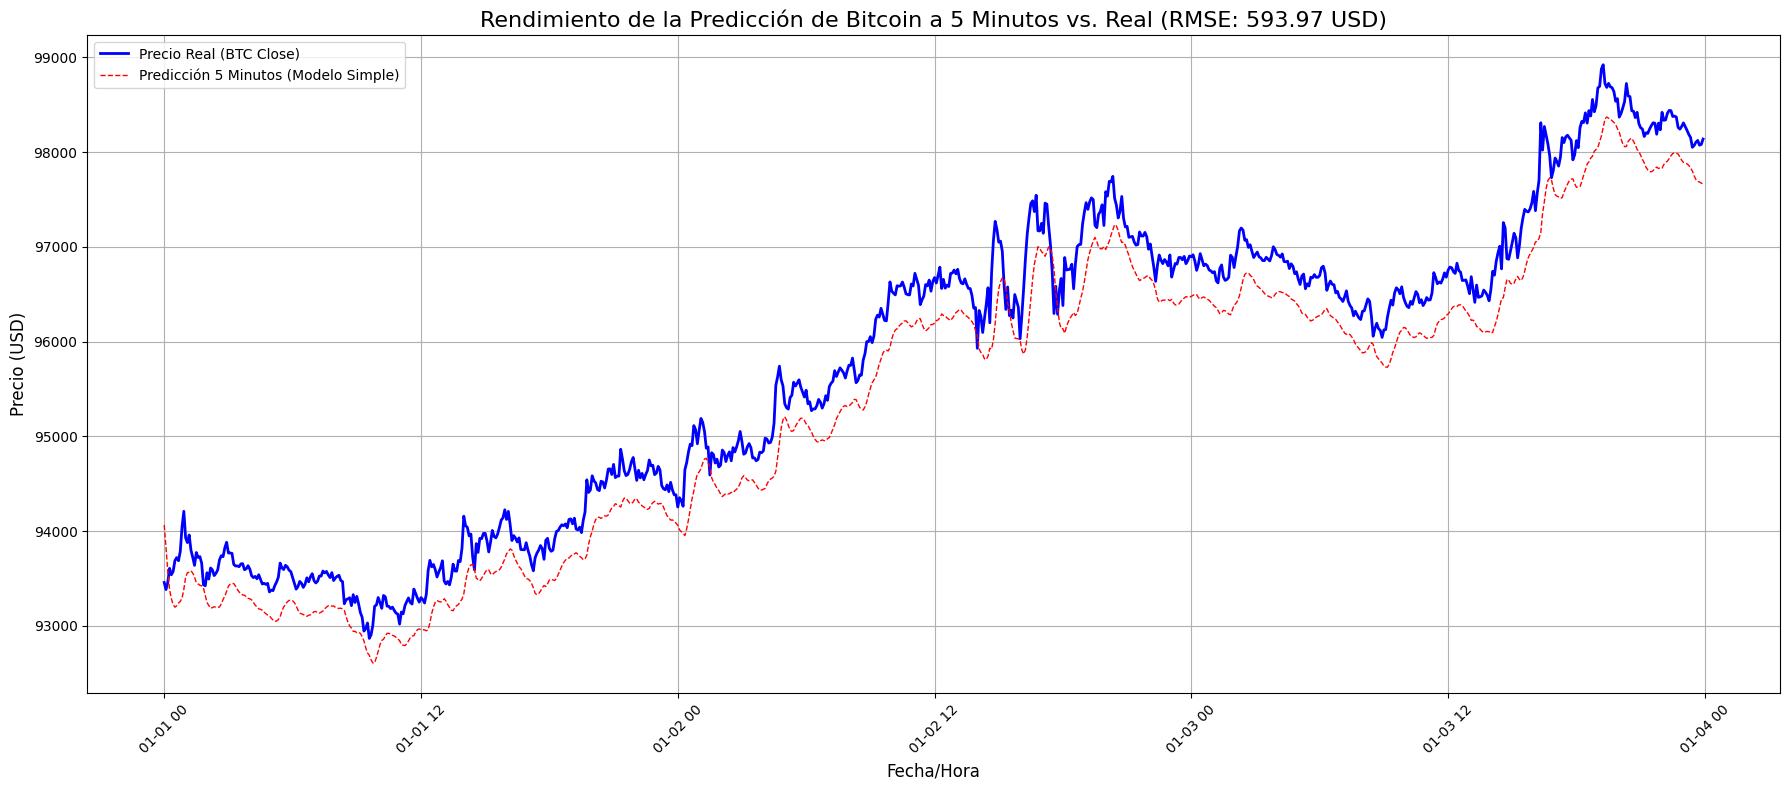


Tareas de predicción y visualización completadas. Tienes el RMSE y el gráfico para tu presentación.


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## 4. EVALUACIÓN Y GRÁFICO FINAL

print("\n--- 4. EVALUACIÓN DE RESULTADOS ---")

# 1. Alinear Precios Reales y Predicciones
precios_reales_final = df_minuto_test_final_alineado.loc[df_prediccion_final.index, 'close'].values
predicciones_finales = df_prediccion_final['pred_final'].values

# 2. Calcular RMSE
rmse = np.sqrt(mean_squared_error(precios_reales_final, predicciones_finales))

print(f"RMSE Final del Modelo (5 Minutos - Modelo simple): {rmse:,.2f} USD")

# 3. Gráfico de Comparación (Solo los primeros 3 días de Enero 2025)
dias_para_graficar = 3 * 12 * 24 

plt.figure(figsize=(18, 8))
plt.plot(df_prediccion_final.index[:dias_para_graficar], precios_reales_final[:dias_para_graficar], label='Precio Real (BTC Close)', color='blue', linewidth=2)
plt.plot(df_prediccion_final.index[:dias_para_graficar], predicciones_finales[:dias_para_graficar], label='Predicción 5 Minutos (Modelo Simple)', color='red', linestyle='--', linewidth=1)

plt.title(f'Rendimiento de la Predicción de Bitcoin a 5 Minutos vs. Real (RMSE: {rmse:,.2f} USD)', fontsize=16)
plt.xlabel('Fecha/Hora', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTareas de predicción y visualización completadas. Tienes el RMSE y el gráfico para tu presentación.")


--- 4. EVALUACIÓN DE RESULTADOS ---
RMSE Final del Modelo (5 Minutos - Modelo simple): 593.97 USD


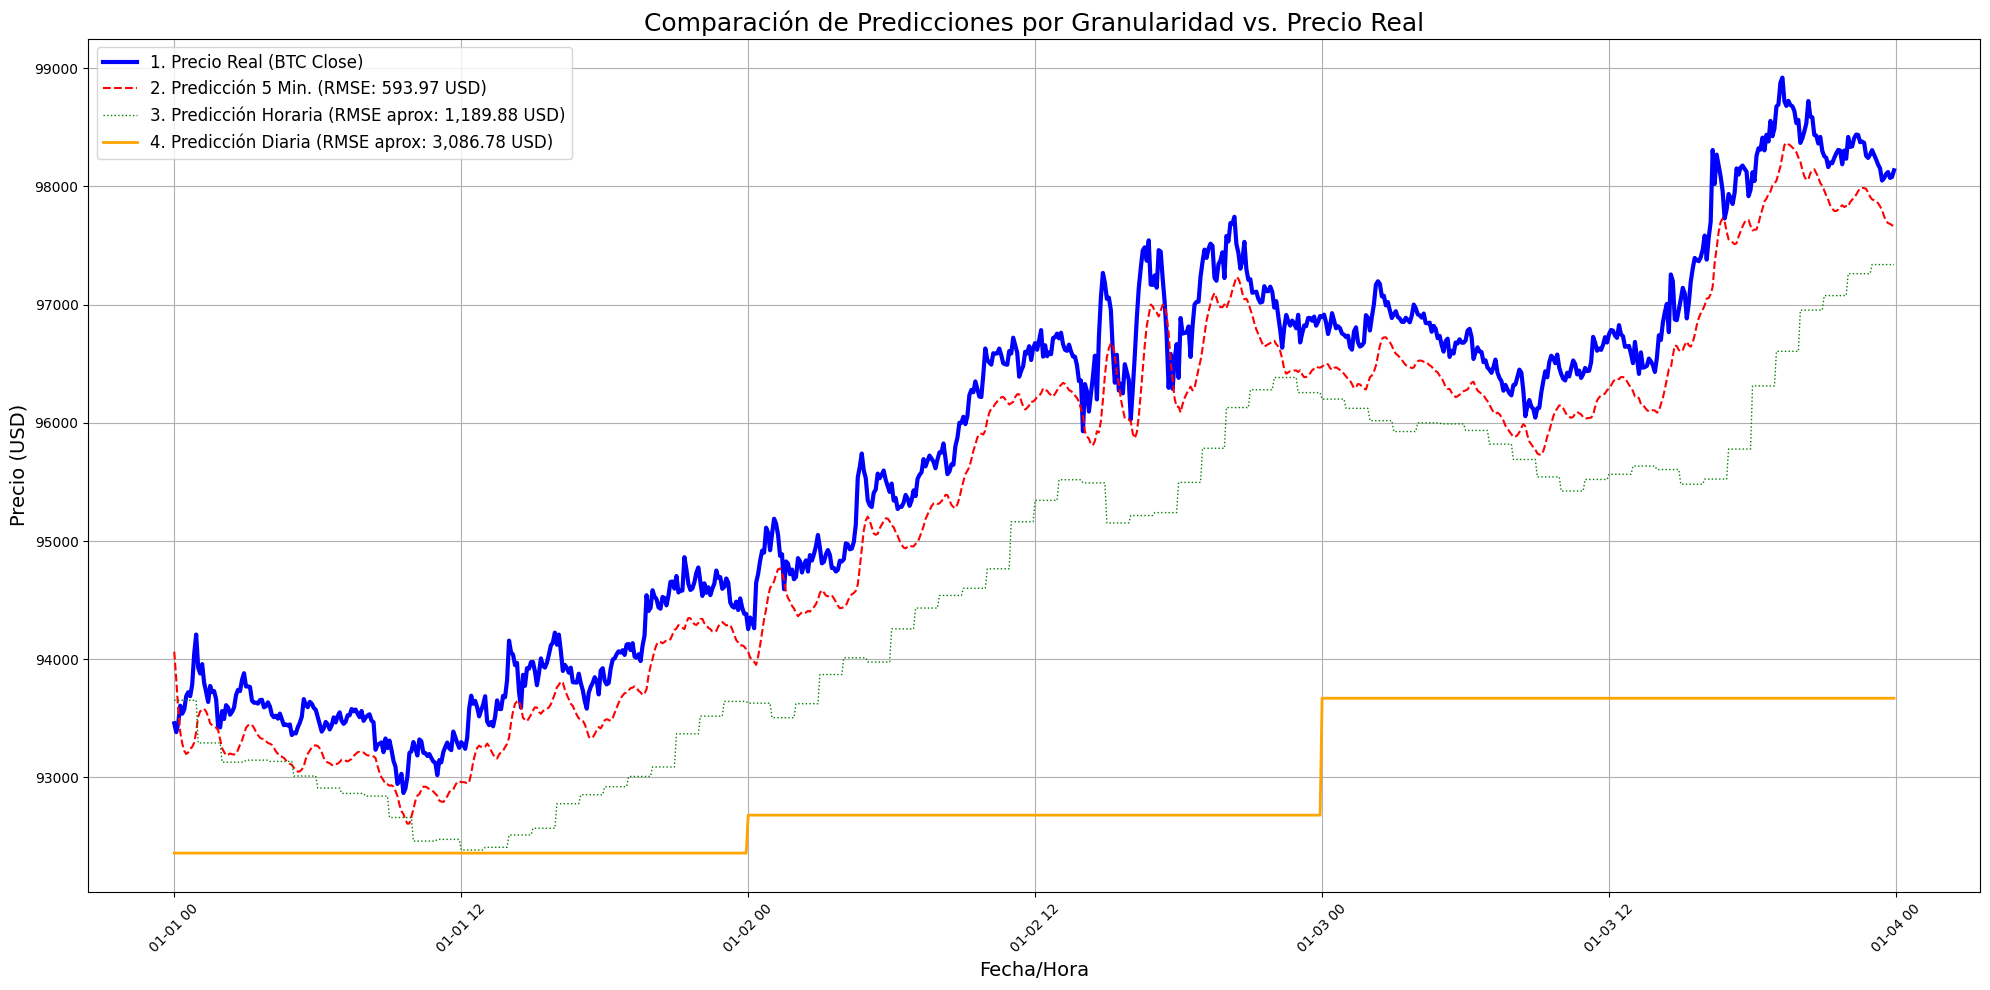


✅ Gráfico de Ensamble de Granularidades generado con éxito.


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

## 4. EVALUACIÓN Y GRÁFICO FINAL (Múltiples Predicciones)

print("\n--- 4. EVALUACIÓN DE RESULTADOS ---")

# 1. Alinear Precios Reales y Predicciones (Alineación base a 5 Minutos)
precios_reales_5min = df_minuto_test_final_alineado.loc[df_prediccion_final.index, 'close'].values
predicciones_finales_5min = df_prediccion_final['pred_final'].values
indices_grafico = df_prediccion_final.index

# 2. INTERPOLACIÓN DE PREDICCIONES a 5 Minutos
# La predicción diaria (una vez al día) se repite para cada paso de 5 minutos de ese día (ffill).
pred_diaria_interpolada = df_prediccion_diaria.reindex(indices_grafico, method='ffill').dropna()
pred_diaria_alineada = pred_diaria_interpolada['pred_diaria'].values

# La predicción horaria (una vez por hora) se repite para cada paso de 5 minutos de esa hora (ffill).
pred_horaria_interpolada = df_prediccion_horaria.reindex(indices_grafico, method='ffill').dropna()
pred_horaria_alineada = pred_horaria_interpolada['pred_horaria'].values

# 3. Calcular RMSE (Solo para el modelo principal de 5 minutos)
rmse_final = np.sqrt(mean_squared_error(precios_reales_5min, predicciones_finales_5min))

print(f"RMSE Final del Modelo (5 Minutos - Modelo simple): {rmse_final:,.2f} USD")

# 4. Gráfico de Comparación (Solo los primeros 3 días de Enero 2025)
# 3 días * 12 pasos/hora * 24 horas/día = 864 pasos
puntos_a_graficar = 3 * 12 * 24 

plt.figure(figsize=(20, 10))

# Precios Reales
plt.plot(indices_grafico[:puntos_a_graficar], 
         precios_reales_5min[:puntos_a_graficar], 
         label='1. Precio Real (BTC Close)', 
         color='blue', 
         linewidth=3)

# Predicción 5 Minutos (El resultado final del modelo)
plt.plot(indices_grafico[:puntos_a_graficar], 
         predicciones_finales_5min[:puntos_a_graficar], 
         label=f'2. Predicción 5 Min. (RMSE: {rmse_final:,.2f} USD)', 
         color='red', 
         linestyle='--', 
         linewidth=1.5)

# Predicción Horaria (Mediano Plazo)
# Calcular RMSE para la predicción horaria para la leyenda
rmse_horario = np.sqrt(mean_squared_error(precios_reales_5min[:puntos_a_graficar], pred_horaria_alineada[:puntos_a_graficar]))
plt.plot(indices_grafico[:puntos_a_graficar], 
         pred_horaria_alineada[:puntos_a_graficar], 
         label=f'3. Predicción Horaria (RMSE aprox: {rmse_horario:,.2f} USD)', 
         color='green', 
         linestyle=':', 
         linewidth=1)

# Predicción Diaria (Largo Plazo)
# Calcular RMSE para la predicción diaria para la leyenda
rmse_diario = np.sqrt(mean_squared_error(precios_reales_5min[:puntos_a_graficar], pred_diaria_alineada[:puntos_a_graficar]))
plt.plot(indices_grafico[:puntos_a_graficar], 
         pred_diaria_alineada[:puntos_a_graficar], 
         label=f'4. Predicción Diaria (RMSE aprox: {rmse_diario:,.2f} USD)', 
         color='orange', 
         linestyle='-', 
         linewidth=2)

plt.title(f'Comparación de Predicciones por Granularidad vs. Precio Real', fontsize=18)
plt.xlabel('Fecha/Hora', fontsize=14)
plt.ylabel('Precio (USD)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n✅ Gráfico de Ensamble de Granularidades generado con éxito.")